In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats import multitest
import pingouin as pg
import scipy.stats as stats
import math
from statsmodels.formula.api import gls, ols
from PIL import Image, ImageDraw, ImageFont

# define directories
data_dir = 'data/datasheets'

out_dir_stats = 'analysis/stats'
out_dir_plots = 'analysis/figures'
os.makedirs(out_dir_stats, exist_ok=True)
os.makedirs(out_dir_plots, exist_ok=True)

/Users/melissa/anaconda3/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# figure settings: size figure according to manuscript requirements
cm_to_inch = 1/2.54
figsize_x = 19 * cm_to_inch
figsize_y = figsize_x/2

sns.set(style = "darkgrid")

# Load data and variables

In [3]:
# load data
data = pd.read_csv(os.path.join(data_dir, 'CombinedThalamicNucleiCorrected_combinedHemis.csv'))
data_preterm = data[data['blsgroup']==1]
data_fullterm = data[data['blsgroup']==2]
print(data.shape)

(175, 19)


In [4]:
# Nuclei and variable lists
nuclei_groups = ['Anterior', 'Lateral', 'Ventral', 'Intralaminar', 'Medial', 'Pulvinar']

# Birth-related variables
birth_vars = ['GA', 'BW', 'inti']

# Behavioural variables
beh_vars = ['wie_gesiq']

# Analysis functions

In [5]:
def calculate_cohens_d(data, nucleus):
    '''
    Calculates Cohen's d to estimate effect sizes.
    data: pandas df
    nucleus: name of nucleus, e.g., 'Medial'
    '''
    
    g1 = data[data['blsgroup'] == 1]
    g2 = data[data['blsgroup'] == 2]
    
    # preterm stats
    mean1 = g1[nucleus].mean()
    std1 = g1[nucleus].std()
    n1 = g1[nucleus].count()
        
    # fullterm stats
    mean2 = g2[nucleus].mean()
    std2 = g2[nucleus].std()
    n2 = g2[nucleus].count()
        
    # cohen's d calculation
    pooled_std = math.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1 + n2 - 2))
    cohen_d = (mean1 - mean2) / pooled_std
    
    return cohen_d

## Significant differences in birth-related and cognitive variables

In [6]:
def run_t_test(data, var_names):
    '''
    Runs two-sample t-test for var_names between groups
    data: dataframe storing relevant data
    var_names: variable names to be compared
    '''
    t_test_results = []

    for var in var_names:
        preterm = data[data['blsgroup'] == 1][var]
        fullterm = data[data['blsgroup'] == 2][var]

        # Perform two-sample t-test
        t_stat, p_val = stats.ttest_ind(preterm, fullterm, nan_policy='omit')

        # Store the results
        t_test_results.append({
            'variable': var,
            'T-statistic': t_stat,
            'p-value': p_val
        })

    # Convert results to a DataFrame
    t_test_df = pd.DataFrame(t_test_results)

    # Apply styling
    t_test_styled = t_test_df.style.applymap(lambda x: highlight_less_than(x, 0.05),
                                            subset=['p-value']).set_caption('T-TEST RESULTS')
    
    return t_test_df, t_test_styled

## 3.2. VP/VLBW adults show consistently lower volume across thalamic nuclei

In [7]:
ancova_pvals = []
ancova_fvals = []
cohens_d_list = []

for nucleus in nuclei_groups:
    ancova = pg.ancova(data=data, dv=nucleus, between='blsgroup', covar=['sex', 'Age_at_scan', 'TIV_corrected'], 
                       effsize='np2')
    ancova_pvals.append(ancova['p-unc'][0])
    ancova_fvals.append(ancova['F'][0])
    
    # calculate cohen's d
    cohens_d_val = calculate_cohens_d(data, nucleus)
    cohens_d_list.append(cohens_d_val)
    
    
# perform correction for multiple comparisons
fdr_ancova = multitest.fdrcorrection(ancova_pvals)[1]

# save summary df
ancova_results = pd.DataFrame({'nucleus': nuclei_groups, 
                           'F-value': ancova_fvals,
                           'p-value': ancova_pvals,
                           'p-fdr': fdr_ancova,
                           'Cohens d': cohens_d_list})
 
ancova_results.reset_index(drop=True, inplace=True)
ancova_results.to_csv(os.path.join(out_dir_stats, 'ANCOVA_results_combined.csv'), index=False)    

ancova_results

,nucleus,F-value,p-value,p-fdr,Cohens d
0,Anterior,10.807175,1.228524e-03,1.228524e-03,-0.723997
1,Lateral,29.741742,1.716053e-07,2.059263e-07,-1.004996
2,Ventral,34.459282,2.226522e-08,3.339783e-08,-1.120166
3,Intralaminar,41.325661,1.252640e-09,7.515838e-09,-1.139659
4,Medial,36.575590,9.066169e-09,1.813234e-08,-1.130684
5,Pulvinar,39.310574,2.882798e-09,8.648393e-09,-1.138380


### Figure 2A

In [8]:
# enter group naming
df = data.copy()
df['blsgroup'] = df['blsgroup'].replace([1,2], ['Preterm', 'Full-term'])

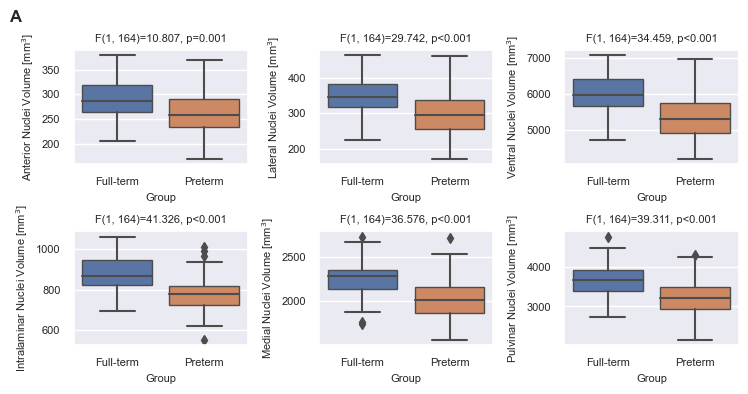

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(figsize_x, figsize_y))
plt.rc('font', size=8)
x='blsgroup'
order=['Full-term', 'Preterm']

for i, ax in enumerate(ax.flat):
    roi_name = nuclei_groups[i]
    y = nuclei_groups[i]
    
    # save relevant F-value and p_fdr
    F_ancova = round(ancova_results['F-value'][i], 3)
    fdr_ancova = ancova_results['p-fdr'][i]
    
    # set sign in image description accordingly
    if fdr_ancova < 0.001:
        fdr_ancova = 0.001
        sign = "<"
    else:
        sign = "="
        fdr_ancova = round(fdr_ancova, 3)
    
    # plot the results
    plot = sns.boxplot(data=df, x=x, y=y, order=order, palette='deep', ax=ax, boxprops=dict(linewidth=1))
    plot.set_xlabel('Group', fontsize=8)
    plot.set_ylabel(f'{roi_name} Nuclei Volume [mm$^3$]', fontsize=8)
    plot.set_title('F(1, 164)={0}, p{1}{2}'.format(F_ancova, sign, fdr_ancova), fontsize=8)
    plot.tick_params(axis='both', which='both', labelsize=8)

plt.tight_layout()

# add "A"
fig.text(0.01, 1, "A", fontsize=12, fontweight='bold')

plt.savefig(os.path.join(out_dir_plots, 'Figure2A.tif'), dpi=800, format='tif')

# Preterm Group Analysis

In [10]:
def calc_corr_vars(glm_data): # calculate necessary variables to plot multiple correlations
    '''
    glm_data: output dataframe from the GLM run on group of interest 
    '''
    p_data = np.array(glm_data['p-value']) # or 'p-fdr'
    x_vars = []
    x_labels = []
    y_vars = []
    y_labels = []
    betas = []
    pvals = []

    for i,p in enumerate(p_data):
        #if p < 0.05:
            
        y = glm_data['Nuclei group'][i]
        y_vars.append(y)
        y_labels.append(f'{y} Nuclei Volume [mm$^3$]')

        x = glm_data['Variable'][i]
        x_vars.append(x)
        #x_labels.append(f'{x}') 
        x_labels.append(f'{x.upper()}') 
            

        betas.append(glm_data['coef'][i])
        pvals.append(p)
    
    return x_vars, x_labels, y_vars, y_labels, betas, pvals

## Volumetric differences in thalamic subregions and their association with INTI

In [11]:
def association_with_volume(nucleus, var, data):
    model = ols(f'{nucleus} ~ {var} + sex + Age_at_scan + TIV_corrected', data=data).fit()
    
    
    summary_dict = {'variable': var,
                    'nucleus': nucleus,
                    'Tstatistic': model.tvalues[1],
                    'coef': model.params[1], # coefficient term (i.e., beta) for x
                    'R2': model.rsquared, 
                    'pvalue': model.pvalues[1]
                   }
    
    summary_df = pd.DataFrame(summary_dict, index=[0])
    return summary_df
    

In [12]:
# relate nuclei volume with INTI, GA, and BW in preterm subjects
association_df = pd.DataFrame(columns=['variable', 'nucleus', 'Tstatistic', 
                                         'coef', 'R2', 'pvalue', 'pfdr'])

for variable in birth_vars:
    for nucleus in nuclei_groups:
        summary_df = association_with_volume(nucleus, variable, data_preterm)
        association_df = pd.concat([summary_df, association_df], axis=0, ignore_index=True)
    
# add FDR correction
association_df['pfdr'] = multitest.fdrcorrection(association_df['pvalue'])[1]

# sort and save
association_df = association_df.sort_index(ascending=False)
association_df = association_df.reset_index(drop=True)
association_df.to_csv(os.path.join(out_dir_stats, 'preterm_glm_summary_stats_birthvars.csv'), index=False)
association_df.sort_values('pfdr')

,variable,nucleus,Tstatistic,coef,R2,pvalue,pfdr
17,inti,Pulvinar,-3.429678,-37.149181,0.474499,0.000974,0.009599
14,inti,Ventral,-3.401173,-48.403554,0.530675,0.001067,0.009599
13,inti,Lateral,-3.144795,-5.342716,0.240226,0.002362,0.014171
16,inti,Medial,-2.963190,-17.257819,0.342050,0.004049,0.018222
5,GA,Pulvinar,2.432216,45.758763,0.436751,0.017298,0.049325
6,BW,Anterior,-2.508093,-0.033833,0.342781,0.014214,0.049325
12,inti,Anterior,-2.392290,-2.664055,0.343934,0.019182,0.049325
7,BW,Lateral,-1.967532,-0.041872,0.183221,0.052677,0.118523
1,GA,Lateral,1.754597,5.190780,0.175237,0.083255,0.162956
15,inti,Intralaminar,-1.714111,-3.328500,0.528988,0.090531,0.162956


### Figure 2B

In [13]:
association_inti = association_df[association_df['variable']=='inti']
association_inti

,variable,nucleus,Tstatistic,coef,R2,pvalue,pfdr
12,inti,Anterior,-2.392290,-2.664055,0.343934,0.019182,0.049325
13,inti,Lateral,-3.144795,-5.342716,0.240226,0.002362,0.014171
14,inti,Ventral,-3.401173,-48.403554,0.530675,0.001067,0.009599
15,inti,Intralaminar,-1.714111,-3.328500,0.528988,0.090531,0.162956
16,inti,Medial,-2.963190,-17.257819,0.342050,0.004049,0.018222
17,inti,Pulvinar,-3.429678,-37.149181,0.474499,0.000974,0.009599


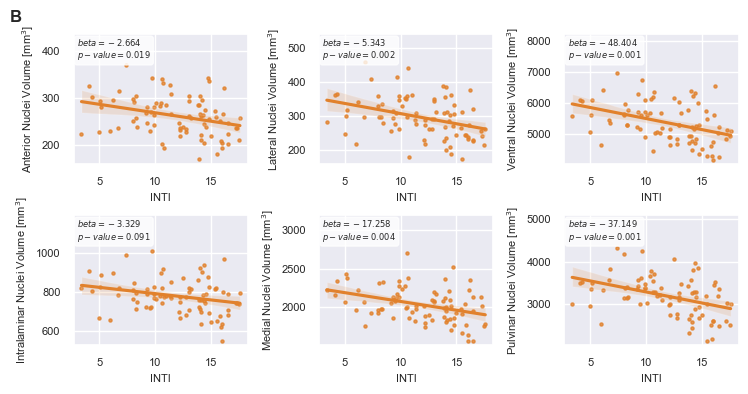

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(figsize_x, figsize_y))
plt.rc('font', size=8)

for i, ax in enumerate(ax.flat):
    plot=sns.regplot(x=data_preterm['inti'], y=data_preterm[nuclei_groups[i]], color='#E1812C', ax=ax,
                    scatter_kws={'s': 5})
    plot.set(ylim=(None, max(data_preterm[nuclei_groups[i]])*1.18))
    plot.set_xlabel('INTI', fontsize=8)
    plot.set_ylabel(nuclei_groups[i]+' Nuclei Volume [mm$^3$]', fontsize=8)
    
    # add textbox
    nuc_results = association_inti.iloc[i,:]
    
    textstr = '\n'.join((
        r'$beta=%.3f$' % (nuc_results.coef),
        r'$p-value=%.3f$' % (nuc_results.pvalue)))
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plot.text(0.02, 0.98, textstr, transform=plot.transAxes, fontsize=6,verticalalignment='top',bbox=props)
    
    ax.tick_params(axis='x', labelsize=8)  # Setting xtick size
    ax.tick_params(axis='y', labelsize=8)  # Setting ytick size
    
plt.tight_layout()

# add "b"
fig.text(0.01, 1, "B", fontsize=12, fontweight='bold')

plt.savefig(os.path.join(out_dir_plots, 'Figure2B.tif'), dpi=800, format='tif')

## 3.3. Lateral, medial, and pulvinar volume reductions were related to worse cognitive performance in VP/VLBW adults

In [15]:
# relate nuclei volume with INTI in preterm subjects
association_df = pd.DataFrame(columns=['variable', 'nucleus', 'Tstatistic', 
                                         'coef', 'R2', 'pvalue', 'pfdr'])

for nucleus in nuclei_groups:
    summary_df = association_with_volume(nucleus, 'wie_gesiq', data_preterm)
    association_df = pd.concat([summary_df, association_df], axis=0, ignore_index=True)
    
# add FDR correction
association_df['pfdr'] = multitest.fdrcorrection(association_df['pvalue'])[1]

# sort and save
association_df = association_df.sort_index(ascending=False)
association_df = association_df.reset_index(drop=True)
association_df.to_csv(os.path.join(out_dir_stats, 'preterm_glm_summary_stats_IQ.csv'), index=False)
association_df = association_df.sort_values('pfdr')
association_df

,variable,nucleus,Tstatistic,coef,R2,pvalue,pfdr
1,wie_gesiq,Lateral,2.067894,1.078115,0.220719,0.042099,0.084198
4,wie_gesiq,Medial,2.179199,4.077059,0.313670,0.032457,0.084198
5,wie_gesiq,Pulvinar,2.129685,7.403838,0.445075,0.036479,0.084198
2,wie_gesiq,Ventral,1.914231,8.708133,0.502213,0.059406,0.089108
3,wie_gesiq,Intralaminar,1.488762,0.868459,0.556954,0.140743,0.168892
0,wie_gesiq,Anterior,0.287010,0.101481,0.310004,0.774896,0.774896


### Figure 3

In [16]:
significant_nuclei=['Lateral', 'Medial', 'Pulvinar']

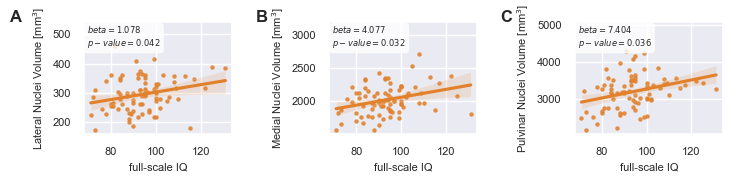

In [17]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(figsize_x, figsize_y/2))
plt.rc('font', size=8)
letters = ['A', 'B', 'C']

for i, ax in enumerate(ax.flat):
    plot=sns.regplot(x=data_preterm['wie_gesiq'], y=data_preterm[significant_nuclei[i]], color='#E1812C', ax=ax,
                    scatter_kws={'s': 5})
    plot.set(ylim=(None, max(data_preterm[significant_nuclei[i]])*1.18))
    plot.set_xlabel('full-scale IQ', fontsize=8)
    plot.set_ylabel(significant_nuclei[i]+' Nuclei Volume [mm$^3$]', fontsize=8)
    
    # add textbox
    nuc_results = association_df.iloc[i,:]
    
    textstr = '\n'.join((
        r'$beta=%.3f$' % (nuc_results.coef),
        r'$p-value=%.3f$' % (nuc_results.pvalue)))
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plot.text(0.02, 0.98, textstr, transform=plot.transAxes, fontsize=6,verticalalignment='top',bbox=props)
    
    ax.tick_params(axis='x', labelsize=8)  
    ax.tick_params(axis='y', labelsize=8)  
    
    # add figure number
    ax.text(-0.5, 1, letters[i], fontsize=12, fontweight='bold',transform=ax.transAxes)
    
    
plt.tight_layout()
plt.savefig(os.path.join(out_dir_plots, 'Figure3.tif'), dpi=800, format='tif')